# ChatGLM2-6b微调保姆级教程 - Colab 版本

- 本notebook适配了Colab的一些tricy issue
- 本notebook对代码进行了较为详细的解释
- Thanks for [有毅力的吃货](https://github.com/lyhue1991/)

## 安装环境

- 注意:与ChatGLM2 相关的依赖使用官方提供的requirement.txt进行安装
- 使用命令行执行`pip install -r requirements.txt`

In [ ]:
#安装环境

#chatglm install by terminal
# !pip install -r requirements.txt

#finetune
!pip install -U accelerate
!pip install datasets
!pip install -U peft
!pip install -U torchkeras

## 展示模型没有进行Finetune之前的能力

In [ ]:
from transformers import  AutoModel,AutoTokenizer
model_name = 'THUDM/chatglm2-6b'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 这里将模型转化成了半精度FP16模式，可以显存优化，可以减少模型在GPU上的显存使用量，但可能会牺牲一定的精度
# 如果你希望使用更高的精度，同时你有足够好的GPU你可以移除这个函数的调用
model = AutoModel.from_pretrained(model_name,trust_remote_code=True).half().cuda()

In [3]:
# define a basic prompt for express comment
# prompt template with 4shots ahead

prompt = """文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。

下面是一些范例:

味道真不错 -> 好评
太辣了，吃不下都  -> 差评
吃完拉肚子了 -> 差评
味道好吃 -> 好评

请对下述评论进行分类。返回'好评'或者'差评'，无需其它说明和解释。

xxxxxx ->

"""

# replace query with real content

def get_prompt(text):
    return prompt.replace('xxxxxx',text)

In [16]:
# try for once and test model workable
response, his = model.chat(tokenizer, get_prompt('味道不错，下次还来'), history=[])
print(response)
print(his)

好评
[("文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。\n\n下面是一些范例:\n\n味道真不错 -> 好评\n太辣了，吃不下都  -> 差评\n吃完拉肚子了 -> 差评\n味道好吃 -> 好评\n\n请对下述评论进行分类。返回'好评'或者'差评'，无需其它说明和解释。\n\n味道不错，下次还来 ->\n\n", '好评')]


In [17]:
# add new history comment as new shots
his.append(("太贵了 -> ","差评"))
his.append(("非常快，味道好 -> ","好评"))

his.append(("这么咸真的是醉了 -> ","差评"))
his.append(("价格感人 优惠多多 -> ","好评"))
# now we got 8 shots
print(his)


[("文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。\n\n下面是一些范例:\n\n味道真不错 -> 好评\n太辣了，吃不下都  -> 差评\n吃完拉肚子了 -> 差评\n味道好吃 -> 好评\n\n请对下述评论进行分类。返回'好评'或者'差评'，无需其它说明和解释。\n\n味道不错，下次还来 ->\n\n", '好评'), ('太贵了 -> ', '差评'), ('非常快，味道好 -> ', '好评'), ('这么咸真的是醉了 -> ', '差评'), ('价格感人 优惠多多 -> ', '好评')]


In [18]:
# based on new shots to make prediction
response, his = model.chat(tokenizer, "一言难尽啊 -> ", history=his)
print(response)

response, his = model.chat(tokenizer, "还凑合一般般 -> ", history=his)
print(response)  # 预测有失偏颇

response, his = model.chat(tokenizer, "我家狗狗爱吃的 -> ", history=his)
print(response)  # 预测有失偏颇

差评
差评
好评


In [19]:
# define a function for above
# only return prediction result rather than result & history
def predict(text):
    response, history = model.chat(tokenizer, f"{text} ->", history=his,
    temperature=0.01)
    return response

predict('死鬼，咋弄得这么有滋味呢') # try for once and got a incompatiable result

'差评'

In [20]:
import pandas as pd
import numpy as np
import datasets

df = pd.read_csv("waimai_10k.csv")

df.head() # 0 是差评，1是好评

,label,review
0,1,很快，好吃，味道足，量大
1,1,没有送水没有送水没有送水
2,1,非常快，态度好。
3,1,方便，快捷，味道可口，快递给力
4,1,菜味道很棒！送餐很及时！


In [21]:
df['tag'] = df['label'].map({0:'差评',1:'好评'}) # create a new column for label
df = df.rename({'review':'text'},axis = 1)

dfgood = df.query('tag=="好评"')
dfbad = df.query('tag=="差评"').head(len(dfgood)) #采样部分差评，让好评差评平衡
df = pd.concat([dfgood,dfbad]) # 重新制作数据集确保数据平衡
print(df['tag'].value_counts())

好评    4000
差评    4000
Name: tag, dtype: int64


In [23]:
# 将Pandas DataFrame对象转换为Hugging Face Dataset对象
# 将数据集划分为训练集和测试集
# test_size: 指定测试集的大小。在这个例子中，测试集的大小是2000，这意味着2000个样本将被用于测试集
# 已知完整的数据集一共包括8000个案例，因此有6000个训练集
# shuffle: 如果设置为True，数据集在划分之前会被打乱，可以确保训练集和测试集是随机抽样的，从而避免因样本排序引起的偏差
# seed: 设置随机数生成器的种子，用于控制随机打乱的过程，确保结果是可复制的。在这里，种子被设置为43，你也可以设置为其他的数字
ds_dic = datasets.Dataset.from_pandas(df).train_test_split(
    test_size = 2000,shuffle=True, seed = 43)
dftrain = ds_dic['train'].to_pandas() # 将训练集转化为pandas
dftest = ds_dic['test'].to_pandas() # 将验证集转化为pandas
# 用于将DataFrame对象保存为Parquet格式的文件
dftrain.to_parquet('dftrain.parquet')
dftest.to_parquet('dftest.parquet')

In [25]:
preds = ['' for x in dftest['tag']] # 基于测试集的长度创建一个新的数组，用于存储测试的结果
print(len(preds))

2000


In [27]:
dftest['pred'] = preds
dftest.head()

,label,text,tag,__index_level_0__,pred
0,0,我的两个中奖瓶盖拿走后就没有下文了，4元可乐居然是灌装的！！！！,差评,6667,
1,1,很好喜欢极力推荐噢,好评,2269,
2,0,商家不把顾客留言放心上，强调不要辣椒，商家还是放了很了很多，弄的孩子无法吃，其他菜品味道不错...,差评,7169,
3,1,速度很快，食品也特别棒！,好评,3687,
4,0,送餐时间，1个小时20分钟！！！！！！电话催单，直接挂客户电话！！！！什么破服务态度！！~！...,差评,6320,


In [29]:
# 对dftest中的每一行文本进行预测，然后把预测结果存储在preds列表中
# 使用当前的未经过ft的模型进行评论类型的预测
from tqdm import tqdm
for i in tqdm(range(len(dftest))):
    text = dftest['text'].loc[i]
    preds[i] = predict(text)

100%|██████████| 2000/2000 [04:14<00:00,  7.86it/s]


In [32]:
dftest['pred'] = preds
dftest.head()

,label,text,tag,__index_level_0__,pred
0,0,我的两个中奖瓶盖拿走后就没有下文了，4元可乐居然是灌装的！！！！,差评,6667,差评
1,1,很好喜欢极力推荐噢,好评,2269,好评
2,0,商家不把顾客留言放心上，强调不要辣椒，商家还是放了很了很多，弄的孩子无法吃，其他菜品味道不错...,差评,7169,差评
3,1,速度很快，食品也特别棒！,好评,3687,好评
4,0,送餐时间，1个小时20分钟！！！！！！电话催单，直接挂客户电话！！！！什么破服务态度！！~！...,差评,6320,差评


In [33]:
# 创建 dftest 的数据透视表
# index='tag': 将'dftest'数据集的'tag'列设置为透视表的索引（行标签）
# columns='pred': 将数据集的'pred'列设置为透视表的列标签
# values='text': 将数据集的'text'列的值填充到透视表中。一般来说，我们会选择一个需要进行计算的列作为values
# aggfunc='count': 聚合函数，定义了我们如何对values进行计算。在这里，我们选择的是'count'，意味着我们要对'text'列的值进行计数
dftest.pivot_table(index='tag',columns = 'pred',values='text',aggfunc='count')

pred,"可能是评论者点的菜品中有带头发的东西,导致自己家狗狗误食了。因此,评论者给了差评。",好评,好评， 加油,差评,"无法确定评价,因为只提供了送到时间,但没有提到是否准时到达。",负面
tag,,,,,,
好评,NaN,809.0,1.0,183.0,1.0,NaN
差评,1.0,54.0,NaN,950.0,NaN,1.0


In [34]:
acc = len(dftest.query('tag==pred'))/len(dftest) # 没有经过ft的model的accuracy为87.95，分数不高也不低
print('accuracy=',acc)

accuracy= 0.8795


## 准备 Finetune 需要的数据


- 需要把数据整理成对话的形式，即 context 和 target 的配对，然后拼到一起作为一条样本
- 几乎所有的LLM都是即给定一段话的上半部分，它会去续写下半部分
- 这里指定上半部分为设计的文本分类任务的prompt，下半部分为文本分类结果
- 微调的目标就是让它预测的下半部分跟我们的设定的文本分类一致



In [55]:
# 加载数据
import pandas as pd
import numpy as np
import datasets

dftrain = pd.read_parquet('dftrain.parquet')
dftest = pd.read_parquet('dftest.parquet')

In [56]:
dftrain.head()

,label,text,tag,__index_level_0__
0,0,"首先送的晚,然后我要的脱脂奶不加冰,做的又加奶又加冰！！！！",差评,7810
1,1,送餐速度快，好吃,好评,1390
2,1,买了两份馅饼只给了一份，也没解释为啥也没退钱,好评,2791
3,0,没给我果汁!!!!!心塞,差评,6327
4,1,很不错，服务非常好，很认真,好评,761


In [57]:
dftest.head()

,label,text,tag,__index_level_0__
0,0,我的两个中奖瓶盖拿走后就没有下文了，4元可乐居然是灌装的！！！！,差评,6667
1,1,很好喜欢极力推荐噢,好评,2269
2,0,商家不把顾客留言放心上，强调不要辣椒，商家还是放了很了很多，弄的孩子无法吃，其他菜品味道不错...,差评,7169
3,1,速度很快，食品也特别棒！,好评,3687
4,0,送餐时间，1个小时20分钟！！！！！！电话催单，直接挂客户电话！！！！什么破服务态度！！~！...,差评,6320


In [58]:
dftrain['tag'].value_counts()

好评    3006
差评    2994
Name: tag, dtype: int64

In [59]:
# 参考chatGLM2 中的输入源码
model.build_inputs??

```python
def build_inputs(self, tokenizer, query: str, history: List[Tuple[str, str]] = None):
        prompt = tokenizer.build_prompt(query, history=history)
        inputs = tokenizer([prompt], return_tensors="pt")
        inputs = inputs.to(self.device)
        return inputs
```

In [60]:
# 将上下文整理成与推理时候一致，参照model.chat中的源码
def build_inputs(query, history):
    prompt = ""
    for i, (old_query, response) in enumerate(history):
        prompt += "[Round {}]\n\n问：{}\n\n答：{}\n\n".format(i + 1, old_query, response) # history中的第几轮次，问了什么，得到了什么答案
    prompt += "[Round {}]\n\n问：{} -> \n\n答：".format(len(history) + 1, query) # 当前轮次，当前问话
    return prompt

In [61]:
print(build_inputs('味道不太行',history=his))

[Round 1]

问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。

下面是一些范例:

味道真不错 -> 好评
太辣了，吃不下都  -> 差评
吃完拉肚子了 -> 差评
味道好吃 -> 好评

请对下述评论进行分类。返回'好评'或者'差评'，无需其它说明和解释。

味道不错，下次还来 ->



答：好评

[Round 2]

问：太贵了 -> 

答：差评

[Round 3]

问：非常快，味道好 -> 

答：好评

[Round 4]

问：这么咸真的是醉了 -> 

答：差评

[Round 5]

问：价格感人 优惠多多 -> 

答：好评

[Round 6]

问：一言难尽啊 -> 

答：差评

[Round 7]

问：还凑合一般般 -> 

答：差评

[Round 8]

问：我家狗狗爱吃的 -> 

答：好评

[Round 9]

问：味道不太行 -> 

答：


In [62]:
dftrain['context'] = [build_inputs(x,history=his) for x in dftrain['text']] # 定义训练集中的上文
dftrain['target'] = [x for x in dftrain['tag']] # 定义训练集中的标签
dftrain = dftrain[['context','target']]

dftest['context'] = [build_inputs(x,history=his) for x in dftest['text']]
dftest['target'] = [x for x in dftest['tag']]
dftest = dftest[['context','target']]

# dftest.head()

# dftrain.head()

,context,target
0,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,差评
1,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,好评
2,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,好评
3,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,差评
4,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,好评


In [64]:
# 将pandas的dataset转化为hf的dataset
ds_train = datasets.Dataset.from_pandas(dftrain)
ds_val = datasets.Dataset.from_pandas(dftest)

In [70]:
ds_train

Dataset({
    features: ['context', 'target'],
    num_rows: 6000
})

## 将数据进行 Tokenizer

In [66]:
# 将输入的文本转化为token也就是Tokenizer
# context转化成context_ids，把target转化成target_ids
# 将context_ids和target_ids拼接到一起作为模型的input_ids

from tqdm import tqdm
import transformers

model_name = "THUDM/chatglm2-6b"
max_seq_length = 512
skip_over_length = True

# 载入模型的Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 载入模型的参数
config = transformers.AutoConfig.from_pretrained(model_name, trust_remote_code=True, device_map='auto')
# 定义预处理流程
def preprocess(example):
    context = example["context"]
    target = example["target"]
    # 将context转化为id 超长就截取
    context_ids = tokenizer.encode(
            context,
            max_length=max_seq_length,
            truncation=True)
    # 将target也转化为id
    target_ids = tokenizer.encode(
        target,
        max_length=max_seq_length,
        truncation=True,
        add_special_tokens=False)
    # 将上述两者的id拼接 + 配置文件中end of sentence 的id
    input_ids = context_ids + target_ids + [config.eos_token_id]

    return {"input_ids": input_ids, "context_len": len(context_ids),'target_len':len(target_ids)}


In [71]:
# 先进行preprocess流程，然后基于该流程的结果选择三个列
ds_train_token = ds_train.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
if skip_over_length: # 基于跳过超长输入内容的条件，将训练集中太长的数据进行剔除
    ds_train_token = ds_train_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [74]:
# 逻辑和上面一致，对验证集的处理
ds_val_token = ds_val.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
if skip_over_length:
    ds_val_token = ds_val_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

## 构建训练管道数据

In [75]:
import torch
# 把一个batch的数据整理成适合模型训练的格式
# 这里需要注意的是训练的思路，输入的信息是上下文 + 结论 + 句号 + padding，但是做loss的部分只有结论的部分 + 句号的部分也就是 target_id + eos_id
def data_collator(features: list):
    len_ids = [len(feature["input_ids"]) for feature in features]
    # 计算出这个batch中的所有样本的 input_ids 长度，并找出最长的长度
    # 之后按照batch中最长的input_ids进行padding，不足的就用空补全
    longest = max(len_ids)
    # 初始化两个空列表 input_ids 和 labels_list，它们用于存储预处理后的输入数据和标签数据
    input_ids = []
    labels_list = []
    # 对 len_ids 和 features 进行合并，然后按照 input_ids 的长度进行逆序排序，也就是说，最长的 input_ids 会排在前面
    for length, feature in sorted(zip(len_ids, features), key=lambda x: -x[0]):
        # 提取出当前样本的 input_ids 和 context_len
        ids = feature["input_ids"]
        context_len = feature["context_len"]
        # 生成标签数据
        # -100 是一个特殊的标记，它表示该位置的损失会在训练时被忽略
        # 标签数据的生成规则：先放入 context_len  个 -100，然后放入 ids 从 context_len 开始到最后的部分，最后再放入 longest - length 个 -100
        labels = (
            [-100] * context_len + ids[context_len :] + [-100] * (longest - length)
        ) #-100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
        # 对 input_ids 进行padding，如果 input_ids 的长度小于最长长度，那么在其后面添加足够数量的 pad_token_id
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        # 将处理过的 input_ids 和 labels 转为 LongTensor 类型，然后添加到相应的列表中
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labels))

    # 将 input_ids 和 labels 的列表堆叠为一个新的tensor
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }

In [76]:
# ds_train_token 是送入训练的数据集
# num_workers 是数据载入时将使用多线程并行处理，这可以在一定程度上加速数据载入
# batch_size 是每一个批次的样本数量
# pin_memory=True: 如果设为 True，那么数据载入器将会在返回Tensor之前，先将其复制到CUDA固定内存中。这样可以使得转移数据到GPU上更快
# shuffle=True: 如果设为 True，那么在每个训练周期开始时，数据载入器将会打乱数据集的顺序
# collate_fn=data_collator: 这个函数定义了如何将多个样本合并成一个小批量。在这里，我们使用之前定义的 data_collator 函数，这个函数会按照我们的需要对每个小批量的数据进行预处理
dl_train = torch.utils.data.DataLoader(ds_train_token,num_workers=2,batch_size=4,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)
dl_val = torch.utils.data.DataLoader(ds_val_token,num_workers=2,batch_size=4,
                                    pin_memory=True,shuffle=True,
                                     collate_fn = data_collator)

In [79]:
dl_train.size = 300 #用约300个step做一次验证

In [85]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# 检查设备后开始训练
# for colab tricky issue
# https://github.com/googlecolab/colabtools/issues/3409
!nvidia-smi

Thu Jul 13 02:34:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    49W / 400W |  12755MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 定义模型：Lora+ChatGLM2-6B

In [86]:
import warnings
warnings.filterwarnings("ignore")

In [88]:
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

# 加载ChatGLM2-6B模型并不以8bit的精度载入
model = AutoModel.from_pretrained("THUDM/chatglm2-6b",
                                  load_in_8bit=False,
                                  trust_remote_code=True)

model.supports_gradient_checkpointing = True  #节约cuda，但可能会使得训练时间变长
model.gradient_checkpointing_enable() # 作用同上
model.enable_input_require_grads() # 作用同上

model.config.use_cache = False  # 关闭了模型的缓存机制，该设置可以避免一些警告，但在模型推理时需要重新开启

# 配置LORA模型的类
# 常规LM任务
# 非推理模式
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
)

# 结合Lora和原有模型
model = get_peft_model(model, peft_config)
# 开启模型的并行处理能力，这可以在有多个GPU的情况下提高训练效率
model.is_parallelizable = True
model.model_parallel = True
# 打印出模型的可训练参数
model.print_trainable_parameters()
# 可训练参数：1949696
# 总参数量：6245533696
# 需要调整的模型参数量的占比还是很低的 3.1%

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

trainable params: 1949696 || all params: 6245533696 || trainable%: 0.031217444255383614


## 训练模型的流程

In [89]:
from torchkeras import KerasModel
from accelerate import Accelerator
# 重写了torchkeras中的StepRunner类
class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None,
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
        if self.stage=='train':
            self.net.train()
        else:
            self.net.eval()

    def __call__(self, batch):

        # 计算loss
        with self.accelerator.autocast():
            # 通过模型self.net对输入数据进行预测，然后用预测结果和标签计算损失, loss的计算过程直接交给ChatGLM2了吗？
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        # 执行梯度下降的步骤
        if self.optimizer is not None and self.stage=="train":
            # 计算每个模型参数关于损失的梯度
            self.accelerator.backward(loss)
            # 执行梯度裁剪（self.accelerator.clip_grad_norm_），防止梯度爆炸
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            # 更新模型参数
            self.optimizer.step()
            # 存在学习率调整器，就调整学习率
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            # 清空梯度
            self.optimizer.zero_grad()

        # 给并行计算和多GPU计算的损失收集起来并求和
        all_loss = self.accelerator.gather(loss).sum()

        # losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}

        # metrics (stateful metrics)
        step_metrics = {}

        # 记录过程信息，追踪模型性能用
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics

KerasModel.StepRunner = StepRunner

# 仅仅保存lora可训练参数
# 覆盖了KerasModel中的load_ckpt和save_ckpt方法
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False

KerasModel.save_ckpt = save_ckpt
KerasModel.load_ckpt = load_ckpt


In [90]:
# 定义模型的训练
# 没有损失函数
# 优化器是adamW
# 学习率 2e-6
# 模型参数存储路径
keras_model = KerasModel(model,loss_fn = None,
        optimizer=torch.optim.AdamW(model.parameters(),lr=2e-6))
ckpt_path = 'waimai_chatglm2'

<<<<<< ⚡️ cuda is used >>>>>>


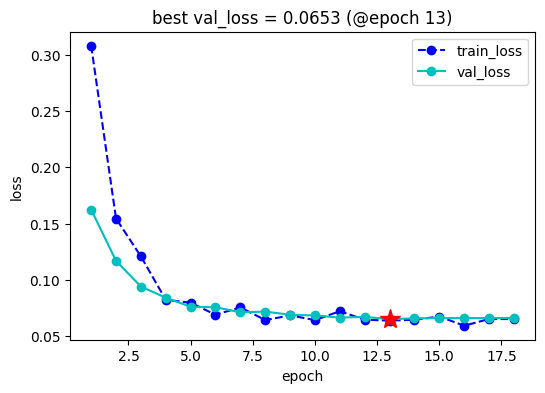

<<<<<< val_loss without improvement in 5 epoch,early stopping >>>>>>


,epoch,train_loss,lr,val_loss
0,1,0.307877,0.000002,0.162481
1,2,0.154576,0.000002,0.116936
2,3,0.120958,0.000002,0.094219
3,4,0.082410,0.000002,0.084321
4,5,0.079885,0.000002,0.076271
5,6,0.069205,0.000002,0.075862
6,7,0.075754,0.000002,0.071373
7,8,0.064483,0.000002,0.071968
8,9,0.068597,0.000002,0.069226
9,10,0.064511,0.000002,0.068553


In [91]:
# 训练一百轮
# patience=5：早停策略的参数，用于防止模型在训练过程中过拟合。如果在连续的5轮训练中，验证损失（或者其他的指定指标）都没有改善，那么训练将会提前停止
# monitor='val_loss'：需要监控的指标：验证损失
# mode='min'：早停策略的参数，指定了改进的方向。'min'意味着指标（这里是验证损失）的最小值被视为改进
# mixed_precision='fp16'：这是一种混合精度训练的策略。在混合精度训练中，一部分张量的数据类型会被设为低精度（如半精度浮点数fp16），这样可以减少计算资源的需求，从而提高训练速度和效率
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,patience=5,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16'
               )

## 验证模型训练后效果

In [92]:
from peft import PeftModel
model = AutoModel.from_pretrained("THUDM/chatglm2-6b",
                                  load_in_8bit=False,
                                  trust_remote_code=True,
                                  device_map='auto')
model = PeftModel.from_pretrained(model,ckpt_path)
model = model.merge_and_unload() #合并lora权重

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [93]:
# def predict(text):
#     response, history = model.chat(tokenizer, f"{text} -> ", history=his,
#     temperature=0.01)
#     return response

predict('死鬼，咋弄得这么有滋味呢')

'差评'

In [95]:
dftest = pd.read_parquet('dftest.parquet')
preds = ['' for x in dftest['text']]
# 重新走一遍对测试数据的验证流程
from tqdm import tqdm
for i in tqdm(range(len(dftest))):
    text = dftest['text'].loc[i]
    preds[i] = predict(text)

100%|██████████| 2000/2000 [04:58<00:00,  6.69it/s]


In [96]:
dftest['pred'] = preds
dftest.pivot_table(index='tag',columns = 'pred',values='text',aggfunc='count')

pred,好评,好评，好评,差评
tag,,,
好评,869.0,1.0,124.0
差评,82.0,NaN,924.0


In [97]:
acc = len(dftest.query('tag==pred'))/len(dftest)
print('acc=',acc)


acc= 0.8965


### Finetune 效果

- 相比于没有Finetune只使用prompt进行任务的模型，准确率提升了2%左右，不算高

## 保存模型

- 注意需要先装载你的Google Drive
- 复制你的 Drive path 并基于 path 修改成下述的代码
- run the code

In [99]:
model.save_pretrained("/content/drive/MyDrive/chatglm2-6b-waimai", max_shard_size='1GB')
tokenizer.save_pretrained("/content/drive/MyDrive/chatglm2-6b-waimai")

('/content/drive/MyDrive/chatglm2-6b-waimai/tokenizer_config.json',
 '/content/drive/MyDrive/chatglm2-6b-waimai/special_tokens_map.json',
 '/content/drive/MyDrive/chatglm2-6b-waimai/tokenizer.model',
 '/content/drive/MyDrive/chatglm2-6b-waimai/added_tokens.json')